In [1]:
import numpy as np
import nibabel as nib

import torch
import torch.nn as nn
import torch.utils.data
import torchvision

from scipy.ndimage import zoom

KeyboardInterrupt: 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
def save_vol_as_nii(numpy_arr, loaded_file, path_to_save):
    empty_header = nib.Nifti1Header()
    Nifti1Image = nib.Nifti1Image(numpy_arr, loaded_file.affine, empty_header)
    nib.save(Nifti1Image, path_to_save)

In [ ]:
brain_file = nib.load("data/sub-299_ses-20110422_desc-angio_N4bfc_brain_mask.nii.gz")
seg_file = nib.load("data/bad_segmentation.nii.gz")


brain_vol = np.array(brain_file.dataobj)
seg_vol = np.array(seg_file.dataobj)

In [ ]:
print(brain_vol.shape)
print(seg_vol.shape)

In [ ]:
seg_vol.max()

In [ ]:
brain_vol_compressed = zoom(brain_vol, (0.25, 0.25, 0.45714285714285713))
seg_vol_compressed = zoom(seg_vol, (0.25, 0.25, 0.45714285714285713))

#brain_vol_compressed = zoom(brain_vol, (0.25/2.0, 0.25/2, 0.45714285714285713/2))
#seg_vol_compressed = zoom(seg_vol, (0.25/2, 0.25/2, 0.45714285714285713/2))


In [ ]:
seg_vol_compressed[seg_vol_compressed>1] = 1
seg_vol_compressed.max()

In [ ]:
brain_vol_compressed = torch.tensor(brain_vol_compressed).unsqueeze(0).unsqueeze(0)
seg_vol_compressed = torch.tensor(seg_vol_compressed).unsqueeze(0).unsqueeze(0)
print(brain_vol_compressed.shape)
print(seg_vol_compressed.shape)

In [ ]:
class conv_block(nn.Module):
    """
    Convolution Block
    """

    def __init__(self, in_channels, out_channels, k_size=3, stride=1, padding=1, bias=True):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=k_size,
                      stride=stride, padding=padding, bias=bias),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size,
                      stride=stride, padding=padding, bias=bias),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """

    # def __init__(self, in_ch, out_ch):
    def __init__(self, in_channels, out_channels, k_size=3, stride=1, padding=1, bias=True):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=k_size,
                      stride=stride, padding=padding, bias=bias),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.up(x)
        return x


class U_Net(nn.Module):
    """
    UNet - Basic Implementation
    Input _ [batch * channel(# of channels of each image) * depth(# of frames) * height * width].
    Paper : https://arxiv.org/abs/1505.04597
    """

    def __init__(self, in_ch=1, out_ch=1):
        super(U_Net, self).__init__()

        n1 = 64 #TODO: make params
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]  # 64,128,256,512,1024

        self.Maxpool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv3d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

        self.active = torch.nn.Sigmoid()

    def forward(self, x):
        # print("unet")
        # print(x.shape)
        # print(padded.shape)

        e1 = self.Conv1(x)
        # print("conv1:")
        # print(e1.shape)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)
        # print("conv2:")
        # print(e2.shape)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)
        # print("conv3:")
        # print(e3.shape)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)
        # print("conv4:")
        # print(e4.shape)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)
        # print("conv5:")
        # print(e5.shape)

        d5 = self.Up5(e5)
        # print("d5:")
        # print(d5.shape)
        # print("e4:")
        # print(e4.shape)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_conv5(d5)
        # print("upconv5:")
        # print(d5.size)

        d4 = self.Up4(d5)
        # print("d4:")
        # print(d4.shape)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)
        # print("upconv4:")
        # print(d4.shape)
        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)
        # print("upconv3:")
        # print(d3.shape)
        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)
        # print("upconv2:")
        # print(d2.shape)
        out = self.Conv(d2)
        # print("out:")
        # print(out.shape)
        # d1 = self.active(out)
        out = self.active(out)
        return [out]

class U_Net_DeepSup(nn.Module):
    """
    UNet - Basic Implementation
    Input _ [batch * channel(# of channels of each image) * depth(# of frames) * height * width].
    Paper : https://arxiv.org/abs/1505.04597
    """

    def __init__(self, in_ch=1, out_ch=1):
        super(U_Net_DeepSup, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]  # 64,128,256,512,1024

        self.Maxpool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        #1x1x1 Convolution for Deep Supervision
        self.Conv_d3 = conv_block(filters[1], 1)
        self.Conv_d4 = conv_block(filters[2], 1)



        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv3d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

        for submodule in self.modules():
            submodule.register_forward_hook(self.nan_hook)

    # self.active = torch.nn.Sigmoid()

    def nan_hook(self, module, inp, output):
        for i, out in enumerate(output):
            nan_mask = torch.isnan(out)
            if nan_mask.any():
                print("In", self.__class__.__name__)
                print(module)
                raise RuntimeError(f"Found NAN in output {i} at indices: ", nan_mask.nonzero(), "where:", out[nan_mask.nonzero()[:, 0].unique(sorted=True)])

    def forward(self, x):
        # print("unet")
        # print(x.shape)
        # print(padded.shape)

        e1 = self.Conv1(x)
        # print("conv1:")
        # print(e1.shape)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)
        # print("conv2:")
        # print(e2.shape)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)
        # print("conv3:")
        # print(e3.shape)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)
        # print("conv4:")
        # print(e4.shape)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)
        # print("conv5:")
        # print(e5.shape)

        d5 = self.Up5(e5)
        # print("d5:")
        # print(d5.shape)
        # print("e4:")
        # print(e4.shape)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_conv5(d5)
        # print("upconv5:")
        # print(d5.size)

        d4 = self.Up4(d5)
        # print("d4:")
        # print(d4.shape)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)
        d4_out  = self.Conv_d4(d4)
        
                
        # print("upconv4:")
        # print(d4.shape)
        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)        
        d3_out  = self.Conv_d3(d3)

        # print("upconv3:")
        # print(d3.shape)
        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)
        # print("upconv2:")
        # print(d2.shape)
        out = self.Conv(d2)
        # print("out:")
        # print(out.shape)
        # d1 = self.active(out)

        return [out, d3_out , d4_out]

In [11]:
model = U_Net()

In [12]:
total_params = sum(
    param.numel() for param in model.parameters()
)
total_params

103536449

In [13]:
model = model.to(device)

In [14]:
brain_vol_compressed = brain_vol_compressed.to(device)
seg_vol_compressed = seg_vol_compressed.to(device)

In [15]:
loss = nn.BCELoss(reduction='mean')
optim = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-06, weight_decay=0.0)

In [16]:
for epoch in range(300):
    optim.zero_grad()
    out = model(brain_vol_compressed)
    out = out[0]
    loss_train = loss(out, seg_vol_compressed.type(torch.float))
    print(loss_train)
    loss_train.backward()
    optim.step()

    
    
    
    

tensor(0.5811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [19]:
out.shape

torch.Size([1, 1, 128, 128, 64])

In [20]:
path_to_save_brain = 'data/brain_vol_compressed.nii.gz'
path_to_save_GT = 'data/seg_vol_compressed_GT.nii.gz'
path_to_save_seg = 'data/seg_vol_compressed.nii.gz'

save_vol_as_nii(brain_vol_compressed[0, 0, :, :, :].detach().cpu().numpy(), brain_file, path_to_save_brain)
save_vol_as_nii(seg_vol_compressed[0, 0, :, :, :].detach().cpu().numpy(), brain_file, path_to_save_GT)
save_vol_as_nii(out[0, 0, :, :, :].detach().cpu().numpy(), brain_file, path_to_save_seg)



In [15]:
empty_header = nib.Nifti1Header()

In [6]:
Nifti1Image = nib.Nifti1Image(brain_vol_compressed, brain_file.affine, empty_header)

In [8]:
nib.save(Nifti1Image, 'data/brain_vol_compressed.nii.gz')

<h2> <b/>Saving example

In [11]:
path_to_brain = "data/sub-299_ses-20110422_desc-angio_N4bfc_brain_mask.nii.gz"
brain_file = nib.load(path_to_brain)
brain_vol = np.array(brain_file.dataobj)
brain_vol_compressed = zoom(brain_vol, (0.25, 0.25, 0.25))

path_to_save = 'data/brain_vol_compressed.nii.gz'
save_vol_as_nii(brain_vol_compressed, brain_file, path_to_save)

In [5]:
import numpy
from stl import mesh

# Using an existing stl file:
seg_mesh = mesh.Mesh.from_file('data/segmentation299.stl')

seg_mesh.save('data/saved_mes.stl')

seg_mesh.y.shape

print(seg_mesh.x)
print(seg_mesh.y)
print(seg_mesh.z)

seg_tensor = np.array([seg_mesh.x.T, seg_mesh.y.T, seg_mesh.z.T])

In [150]:
from pydicom import dcmread
import pylibjpeg
import os
import numpy as np
import nibabel as nib

path_to_slices = '/home/msst/Documents/medtech/KT/95896/95896/'
slices_names = os.listdir(path=path_to_slices)

print(len(slices_names))
#print(sorted(slices_names))

623


In [151]:
d = {"a":[1, 2, 3]}
print(d.get("b"))

None


In [152]:
def get_dcm_info(path_to_dcm):
    slices_names = os.listdir(path=path_to_slices)
    datasets_dict = {}
    for name in slices_names:
        dcm_file = dcmread(path_to_slices + name)
        sd = dcm_file.SeriesDescription
        if (datasets_dict.get(sd) is None):
            datasets_dict.update({
                sd : {
                    "vol_shape" : None,
                    "vox_size" : None,
                    "file_names" : [name,]
                }    
            })
        else:
            datasets_dict[sd]["file_names"].append(name)
    for key in datasets_dict.keys():
        dcm_file = dcmread(path_to_dcm + datasets_dict[key]["file_names"][0])
        rows = dcm_file.Rows
        columns = dcm_file.Columns
        depth = len(datasets_dict[key]["file_names"])
        sizes = (rows, columns, depth)
        datasets_dict[key]["vol_shape"] = sizes
         
        if hasattr(dcm_file, 'SpacingBetweenSlices') and hasattr(dcm_file, "PixelSpacing"):
            voxel_size = (dcm_file.PixelSpacing[0], dcm_file.PixelSpacing[1], dcm_file.SpacingBetweenSlices)
            datasets_dict[key]["vox_size"] = voxel_size
            
    return(datasets_dict)

In [153]:
d = get_dcm_info(path_to_slices)
d.keys()

dict_keys(['Axial Brain, iDose (4)', 'Axial Skull, iDose (3)', 'Exam Summary', 'SURVIEW'])

In [154]:
def get_dcm_vol(path_to_slices, study_dict):
    vol_shape = study_dict["vol_shape"] 
    vox_size = study_dict["vox_size"]        
    
    dcm_file = dcmread(path_to_slices + study_dict["file_names"][0])
    dtype = type(dcm_file.pixel_array[0][0])
    vol = np.zeros(vol_shape, dtype=dtype)
    
    for indx, name in enumerate(sorted(study_dict["file_names"])):
        #print(indx, name)
        dcm_file = dcmread(path_to_slices + name)
        
        vol[:, :, indx] = dcm_file.pixel_array
    
    return(vol, vox_size)

In [166]:
def vox_size2affine(vox_size):
    return [[vox_size[0], 0., 0., 0.],
            [0., vox_size[1], 0., 0.],
            [0., 0., vox_size[2], 0.],
            [0., 0., 0., 1.]]


def save_vol_as_nii(numpy_arr, affine, path_to_save):
    empty_header = nib.Nifti1Header()
    Nifti1Image = nib.Nifti1Image(numpy_arr, affine, empty_header)
    nib.save(Nifti1Image, path_to_save)

In [164]:
vol, vox_size = get_dcm_vol(path_to_slices, d['Axial Skull, iDose (3)'])

In [167]:
path_to_save_ct = 'seg_data/CT_data2.nii.gz'
save_vol_as_nii(vol, vox_size2affine(vox_size), path_to_save_ct)

MONOCHROME2
[0.2838542, 0.2838542]
1


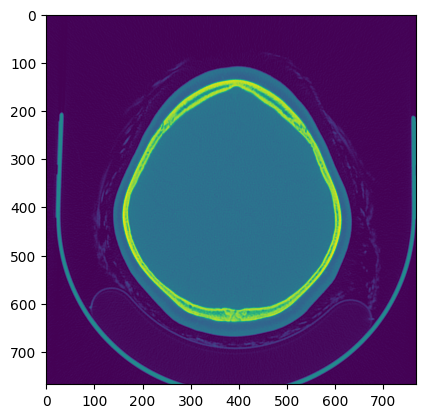

In [111]:
from pydicom import dcmread
import pylibjpeg

path = "/home/msst/Documents/medtech/KT/95896/95896/0200021C"
ds = dcmread(path)
print(ds.PhotometricInterpretation)
print(ds.PixelSpacing)
print(ds.SliceThickness)
#ds.PhotometricInterpretation = 'YBR_FULL'
arr = ds.pixel_array
plt.imshow(arr)
plt.show()

In [112]:
print(path)
print(ds)

/home/msst/Documents/medtech/KT/95896/95896/0200021C
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 316
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.33.1.63789608691564117700001.5558069625841879060
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.195.3.1.7230010.3
(0002, 0013) Implementation Version Name         SH: 'ISP_DCX_V3_1'
(0002, 0100) Private Information Creator UID     UI: 1.2.826.0.1.3680043.8.195.3.1.20041017
(0002, 0102) Private Information                 OB: Array of 42 elements
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(000